In [ ]:
!pip install ppscore
!pip install catboost
!pip install sweetviz
!pip install bayesian_optimization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import ppscore as pps

import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_colwidth', -1)

import warnings
warnings.simplefilter('ignore')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [ ]:
%cd drive/My\ Drive/house_prices

/content/drive/My Drive/house_prices


In [ ]:
ss = pd.read_csv('input/sample_submission.csv')
train = pd.read_csv('input/Train.csv')
test = pd.read_csv('input/Test.csv')

In [ ]:
ss.head()

,TARGET(PRICE_IN_LACS)
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
train.head()
test.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE
0,Owner,0,0,1,BHK,545.171340,1,1,"Kamrej,Surat",21.262000,73.047700
1,Dealer,1,1,2,BHK,800.000000,0,0,"Panvel,Lalitpur",18.966114,73.148278
2,Dealer,0,0,2,BHK,1257.096513,1,1,"New Town,Kolkata",22.592200,88.484911
3,Dealer,0,0,3,BHK,1400.329489,1,1,"Kalwar Road,Jaipur",26.988300,75.584600
4,Owner,0,0,1,BHK,430.477830,1,1,"Mai Mandir,Nadiad",22.700000,72.870000


In [ ]:
train.shape 
test.shape

(29451, 12)

(68720, 11)

In [ ]:
train.columns

Index(['POSTED_BY', 'UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK',
       'SQUARE_FT', 'READY_TO_MOVE', 'RESALE', 'ADDRESS', 'LONGITUDE',
       'LATITUDE', 'TARGET(PRICE_IN_LACS)'],
      dtype='object')

In [ ]:
for c in train.columns:
    print(train[c].value_counts())

Dealer     18291
Owner      10538
Builder    622  
Name: POSTED_BY, dtype: int64
0    24157
1    5294 
Name: UNDER_CONSTRUCTION, dtype: int64
0    20088
1    9363 
Name: RERA, dtype: int64
2     13324
3     10546
1     3574 
4     1723 
5     190  
6     52   
7     11   
8     10   
15    4    
10    4    
20    4    
12    3    
9     3    
13    1    
11    1    
17    1    
Name: BHK_NO., dtype: int64
BHK    29427
RK     24   
Name: BHK_OR_RK, dtype: int64
1000.000000    479
1250.000000    294
800.000000     202
1200.000000    179
1600.000000    125
              ... 
1749.908859    1  
1684.001981    1  
1864.207221    1  
1383.862040    1  
1532.889018    1  
Name: SQUARE_FT, Length: 19561, dtype: int64
1    24157
0    5294 
Name: READY_TO_MOVE, dtype: int64
1    27377
0    2074 
Name: RESALE, dtype: int64
Zirakpur,Chandigarh                         509
Whitefield,Bangalore                        230
Raj Nagar Extension,Ghaziabad               215
Sector-137 Noida,Noida          

In [ ]:
target_col = 'TARGET(PRICE_IN_LACS)'
features = [c for c in train.columns if c not in [target_col,'POSTED_BY']]

In [ ]:
cat_cols = ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'BHK_OR_RK', 'READY_TO_MOVE', 'RESALE']
num_cols = ['SQUARE_FT', 'LONGITUDE', 'LATITUDE']

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29451 entries, 0 to 29450
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   POSTED_BY              29451 non-null  object 
 1   UNDER_CONSTRUCTION     29451 non-null  int64  
 2   RERA                   29451 non-null  int64  
 3   BHK_NO.                29451 non-null  int64  
 4   BHK_OR_RK              29451 non-null  object 
 5   SQUARE_FT              29451 non-null  float64
 6   READY_TO_MOVE          29451 non-null  int64  
 7   RESALE                 29451 non-null  int64  
 8   ADDRESS                29451 non-null  object 
 9   LONGITUDE              29451 non-null  float64
 10  LATITUDE               29451 non-null  float64
 11  TARGET(PRICE_IN_LACS)  29451 non-null  float64
dtypes: float64(4), int64(5), object(3)
memory usage: 2.7+ MB


## EDA


In [ ]:
train['BHK_OR_RK'].value_counts()

BHK    29427
RK     24   
Name: BHK_OR_RK, dtype: int64

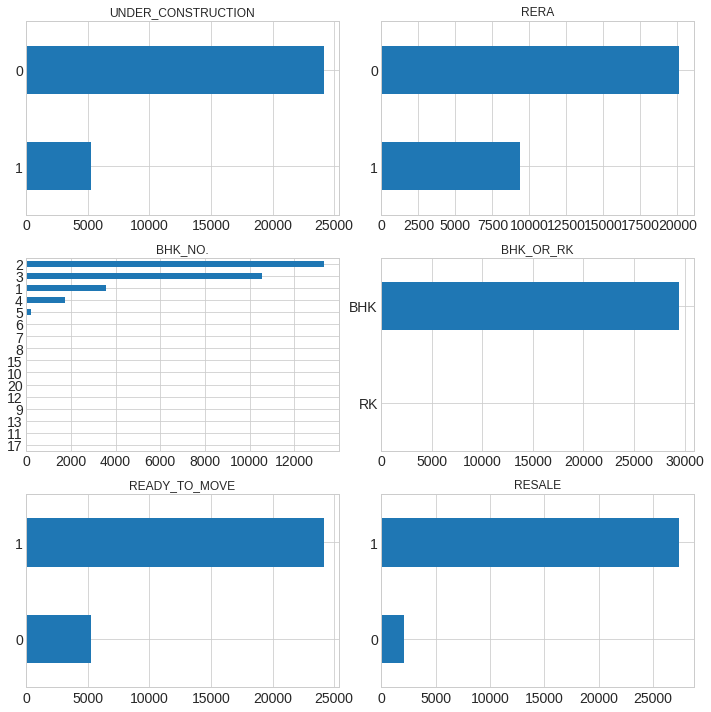

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = [ax for axes_row in axes for ax in axes_row]

for i, c in enumerate(train[cat_cols]):
    _ = train[c].value_counts()[::-1].plot(kind = 'barh', ax=axes[i], title=c, fontsize=14)
    
_ = plt.tight_layout()

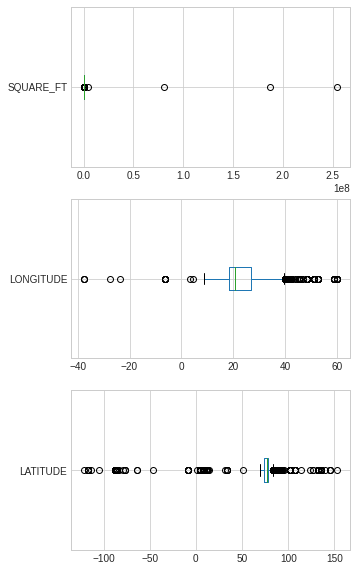

In [ ]:
fig, axes = plt.subplots(len(num_cols), 1, figsize=(5, 10))
for i, c in enumerate(num_cols):
  _ = train[[c]].boxplot(ax=axes[i], vert=False)

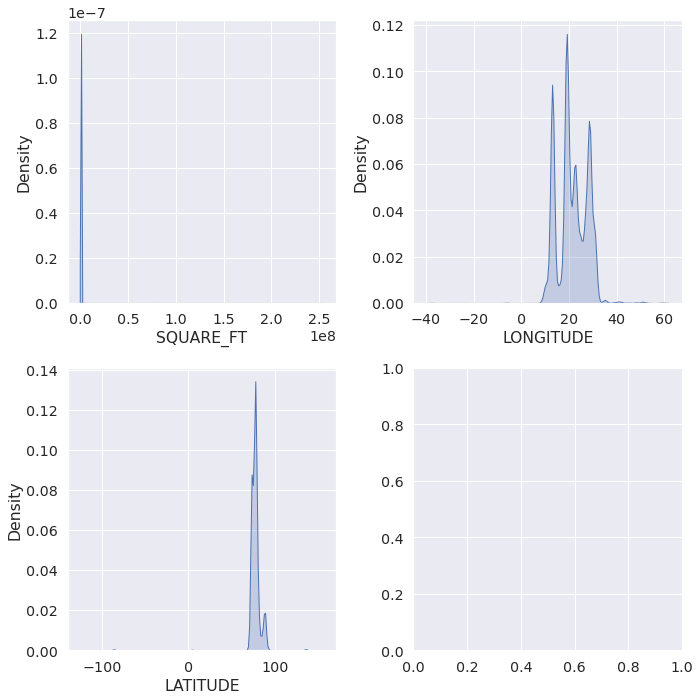

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
  plot = sns.kdeplot(data=train, x=c, ax=axes[i], fill=True)
plt.tight_layout()

In [ ]:
train['SQUARE_FT'].describe().astype('int')

count    29451    
mean     19802    
std      1901334  
min      3        
25%      900      
50%      1175     
75%      1550     
max      254545454
Name: SQUARE_FT, dtype: int64

In [ ]:
def nor(x):
  sk=x.skew()
  sq=(np.sqrt(x)).skew()
  lg=(np.log1p(x)).skew()
  return {"skew":sk,"sqrt":sq,"log":lg}

In [ ]:
t=pd.concat([train,test],ignore_index=True)

<Figure size 720x360 with 0 Axes>

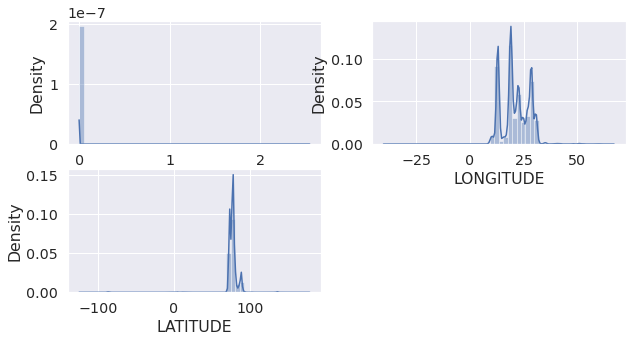

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
sns.distplot(t.SQUARE_FT)
plt.subplot(2,2,2)
sns.distplot(t.LONGITUDE)
plt.subplot(2,2,3)
sns.distplot(t.LATITUDE)

In [ ]:
from IPython.display import display
display(print("1. SQUARE_FT"))
display(nor(t.SQUARE_FT))
display(print("2. LONGITUDE"))
display(nor(t.LONGITUDE))
display(print("3. LATITUDE"))
nor(t.LATITUDE)

1. SQUARE_FT


None

{'log': 2.4504431135495994,
 'skew': 208.0674162087385,
 'sqrt': 148.60269719974823}

2. LONGITUDE


None

{'log': -0.3329818553341796,
 'skew': 0.14970046514929986,
 'sqrt': -0.06004820509654904}

3. LATITUDE


None

{'log': -15.053363323223044,
 'skew': -10.361157253849871,
 'sqrt': -6.1247261877342}

## Feature Engineering

In [ ]:
t=pd.concat([train,test],ignore_index=True)

In [ ]:
t.shape
t.head(10)

(98171, 12)

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
5,Owner,0,0,3,BHK,1250.000000,1,1,"South Chittoor,Kochi",10.033280,76.282571,42.0
6,Dealer,0,0,3,BHK,1495.053957,1,1,"Sodala,Jaipur",26.916347,75.795600,66.5
7,Owner,0,1,3,BHK,1181.012946,1,1,"Kharar,Mohali",30.740000,76.650000,52.0
8,Dealer,0,1,2,BHK,1040.000000,1,1,"Bileshivale,Bangalore",13.054202,77.674002,41.6
9,Owner,0,1,2,BHK,879.120879,1,1,"Chromepet,Chennai",12.951610,80.140970,36.0


In [ ]:
t = t.drop('POSTED_BY', axis=1)

In [ ]:
t = t.drop('BHK_OR_RK', axis=1)

In [ ]:
t.SQUARE_FT = np.log1p(t.SQUARE_FT)

In [ ]:
t['long_scaled'] = np.sqrt(t.LONGITUDE)
t['lat_scaled'] = np.sqrt(t.LATITUDE)

In [ ]:
t['ADDRESS'] = t['ADDRESS'].apply(lambda x: pd.Series(str(x).split(',')[1]))

### Clustering Geocoords

In [ ]:
kmeans = KMeans(n_clusters=10)

In [ ]:
clusters = kmeans.fit_predict(t[['LONGITUDE','LATITUDE']])
t['clusters'] = clusters

In [ ]:
cl = pd.DataFrame({'Add':t.ADDRESS,'Clust':t.clusters})
cl.head(50)

,Add,Clust
0,Bangalore,4
1,Mysore,4
2,Bangalore,4
3,Ghaziabad,3
4,Kolkata,2
5,Kochi,4
6,Jaipur,3
7,Mohali,3
8,Bangalore,4
9,Chennai,4


### Urban Rural Mapping

In [ ]:
t.head(2)

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),long_scaled,lat_scaled,clusters
0,0,0,2,7.171070,1,1,Bangalore,12.969910,77.597960,55.0,3.601376,8.80897,4
1,0,0,2,7.151485,1,1,Mysore,12.274538,76.644605,51.0,3.503504,8.75469,4


In [ ]:
tiers = pd.read_excel('citiestiers.xlsx',sheet_name=1)

In [ ]:
tier2list = tiers.loc[tiers['Tier']=='Tier-II','City'].tolist()

In [ ]:
t1_cities = ['Delhi','Hyderabad','Bangalore','Mumbai','Chennai','Kolkata']
t1_cities = [city.strip().lower() for city in t1_cities]
t2_cities = ["".join(city.lower().split()) for city in tier2list]

In [ ]:
def city_tier_map(city):
    if "".join(city.lower().split()) in t1_cities:
        return 2
    elif "".join(city.lower().split()) in t2_cities:
        return 1
    else:
        return 0

In [ ]:
t['Tier'] = t['ADDRESS'].apply(city_tier_map)

In [ ]:
t.head(2)

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),long_scaled,lat_scaled,clusters,Tier
0,0,0,2,7.171070,1,1,Bangalore,12.969910,77.597960,55.0,3.601376,8.80897,4,2
1,0,0,2,7.151485,1,1,Mysore,12.274538,76.644605,51.0,3.503504,8.75469,4,1


In [ ]:
t["sqft/bhk"]=t.SQUARE_FT/t['BHK_NO.']
t["long/lat"]=t.LONGITUDE/t.LATITUDE

# t["mass/std"]=t.mass_npea/t.std_dev_malign
# t["error/std"]=t.err_malign/t.std_dev_malign
# t["m/a*s"]=t["mass/exposed_area"]*t.damage_size
# t["m/a_sqrt"]=np.sqrt(t["mass/exposed_area"])
# t["error-penalty"]=t.damage_ratio-t.malign_ratio
# t["FE1"]=t["mass/exposed_area"]*t["p/e"]
# t["FE2"]=t["mass/exposed_area"]*t["mass/std"]
# t["FE3"]=t.malign_ratio+t.std_dev_malign
# t["FE4"]=t.damage_ratio-t.std_dev_malign
# t["FE5"]=t["m/a*s"]-t.malign_ratio

In [ ]:
t.drop('ADDRESS', axis=1, inplace=True)

In [ ]:
t.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),long_scaled,lat_scaled,clusters,Tier,sqft/bhk,long/lat
0,0,0,2,7.171070,1,1,12.969910,77.597960,55.0,3.601376,8.808970,4,2,3.585535,0.167142
1,0,0,2,7.151485,1,1,12.274538,76.644605,51.0,3.503504,8.754690,4,1,3.575743,0.160149
2,0,0,2,6.839647,1,1,12.778033,77.632191,43.0,3.574637,8.810913,4,2,3.419824,0.164597
3,0,1,2,6.836175,1,1,28.642300,77.344500,62.5,5.351850,8.794572,3,1,3.418087,0.370321
4,1,0,2,6.907765,0,1,22.592200,88.484911,60.5,4.753125,9.406642,2,2,3.453882,0.255323


In [ ]:
trn = t[0:train.shape[0]]
tst = t[train.shape[0]:]

In [ ]:
tst.isnull().sum()

UNDER_CONSTRUCTION       0    
RERA                     0    
BHK_NO.                  0    
SQUARE_FT                0    
READY_TO_MOVE            0    
RESALE                   0    
LONGITUDE                0    
LATITUDE                 0    
TARGET(PRICE_IN_LACS)    68720
long_scaled              26   
lat_scaled               188  
clusters                 0    
Tier                     0    
sqft/bhk                 0    
long/lat                 0    
dtype: int64

In [ ]:
trn['lat_scaled'].fillna(trn['lat_scaled'].mean(), inplace=True)
trn['long_scaled'].fillna(trn['long_scaled'].mean(), inplace=True)
tst['lat_scaled'].fillna(tst['lat_scaled'].mean(), inplace=True)
tst['long_scaled'].fillna(tst['long_scaled'].mean(), inplace=True)

In [ ]:
tst.drop('TARGET(PRICE_IN_LACS)', axis=1, inplace=True)

In [ ]:
trn.tail()
tst.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),long_scaled,lat_scaled,clusters,Tier,sqft/bhk,long/lat
29446,0,0,3,7.824446,1,1,27.140626,78.043277,45.0,5.209667,8.834211,3,1,2.608149,0.347764
29447,0,0,2,6.646690,1,1,39.945409,-86.150721,16.0,6.320238,8.782108,1,0,3.323345,-0.463669
29448,0,0,2,6.931122,1,1,26.928785,75.828002,27.1,5.189295,8.707928,3,1,3.465561,0.355130
29449,0,0,2,6.833117,1,1,12.900150,80.227910,67.0,3.591678,8.957003,4,2,3.416558,0.160794
29450,0,1,2,6.799919,1,1,26.832353,75.841749,27.8,5.179995,8.708717,3,1,3.399959,0.353794


,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,long_scaled,lat_scaled,clusters,Tier,sqft/bhk,long/lat
29451,0,0,1,6.302933,1,1,21.262000,73.047700,4.611074,8.546795,0,1,6.302933,0.291070
29452,1,1,2,6.685861,0,0,18.966114,73.148278,4.355010,8.552677,0,0,3.342930,0.259283
29453,0,0,2,7.137355,1,1,22.592200,88.484911,4.753125,9.406642,2,2,3.568678,0.255323
29454,0,0,3,7.245177,1,1,26.988300,75.584600,5.195026,8.693940,3,1,2.415059,0.357061
29455,0,0,1,6.067216,1,1,22.700000,72.870000,4.764452,8.536393,0,0,6.067216,0.311514


In [ ]:
cat_cols = ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'READY_TO_MOVE', 'RESALE', 'clusters','Tier']
num_cols = [c for c in tst.columns if c not in cat_cols]
features = [c for c in tst.columns]
target_col = 'TARGET(PRICE_IN_LACS)'

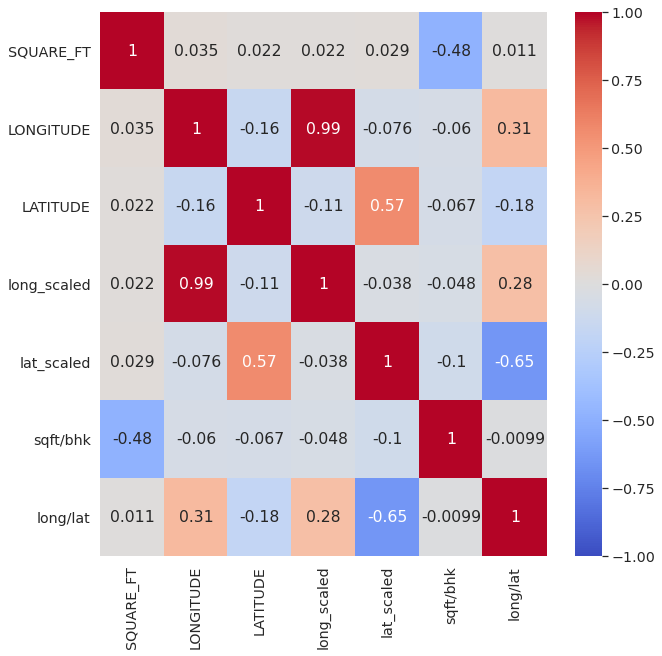

In [ ]:
##correlation matrix. Feature elimination based on multicollinearity
df_corr = trn[num_cols]
corr=df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmin=-1,cmap='coolwarm',annot=True);#,mask=mask);

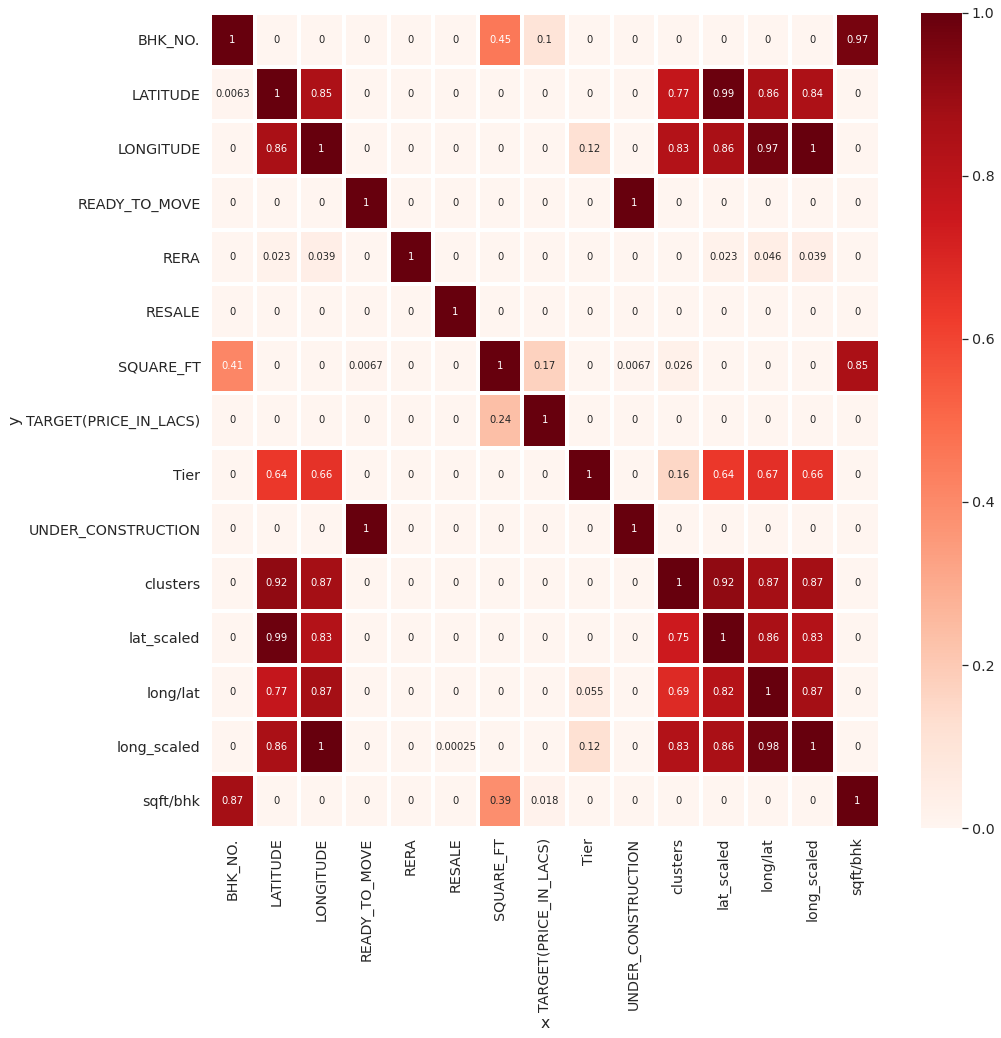

In [ ]:
df=pps.matrix(trn)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
fig, ax = plt.subplots(figsize=(15,15)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

In [ ]:
# import scipy.stats as stat
# import pylab
# def plot_data(df,feature):
#     plt.figure(figsize=(10,6))
#     plt.title(feature)
#     plt.subplot(1,2,1)
#     df[feature].hist()
#     plt.subplot(1,2,2)
#     stat.probplot(df[feature],dist='norm',plot=pylab)
#     plt.show()
# for c in num_cols:
#     plot_data(trn, c)

# Model

In [ ]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.23.2)


In [ ]:
from sklearn.model_selection import StratifiedKFold, KFold
from bayes_opt import BayesianOptimization
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error
from sklearn.preprocessing import minmax_scale
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor

### Evaluation Metric

In [ ]:
def RMSLE(y_true, y_pred):
    minmax_scale(y_true, feature_range=(0,1))
    minmax_scale(y_pred, feature_range=(0,1))
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle = make_scorer(RMSLE, greater_is_better=False)

## Crossval Strat

In [ ]:
#Hyperparameter tuning of LightGBM Regressor using Bayesian optimization

def lgb_cv(n_estimators, num_leaves, min_child_samples, subsample, data, targets):
    estimator = LGBMRegressor(
        n_estimators=n_estimators,
        num_leaves = num_leaves,
        min_child_samples=min_child_samples,
        subsample = subsample,
        random_state = 2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring=rmsle_score, cv=5)
    return cval.mean()

def optimize_lgb(data, targets):
    def lgb_crossval(n_estimators, num_leaves, min_child_samples, subsample):
        return lgb_cv(
            n_estimators=int(n_estimators),
            num_leaves = int(num_leaves),
            min_child_samples=int(min_child_samples),
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=lgb_crossval,
        pbounds={
            "n_estimators": (200,500),
            "num_leaves": (30,80),
            "min_child_samples": (5,30),
            "subsample": (0.6,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=25, init_points=20)

    print("Final result:", optimizer.max)

In [ ]:
estimator = LGBMRegressor(
        n_estimators=300,
        num_leaves = 50,
        min_child_samples=15,
        subsample = 0.8,
        random_state = 2
    )

In [ ]:
pd.options.display.max_seq_items = 2000

In [ ]:
l = []
splits = 5
kfold, scores = KFold(n_splits=splits,random_state=True), list()
for train, test in kfold.split(trn,target):
    x_train, x_test = trn.values[train], trn.values[test]
    y_train, y_test = target.values[train], target.values[test]
    model = estimator
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    print("preds",preds)
    feature_importances = pd.DataFrame(model.feature_importances_,
                                    index = trn.columns,
                                    columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    for i in preds:
        if i<0:
            print("i",i)
    score = np.sqrt(np.sqrt(mean_squared_log_error(y_test, preds)))
    scores.append(score)
    print("Score is", score)

print("Average:", np.sum(scores)/len(scores))

LGBMRegressor(min_child_samples=15, n_estimators=300, num_leaves=50,
              random_state=2, subsample=0.8)

preds [ 79.78500601  55.9481803   41.45240113 ... 163.70064669  36.11049395
  45.07146443]
i -20.800962943475405
i -0.39580085958536404
i -1.2845355851719422
i -18.592815780646735
i -46.29137132941054
i -305.9278262377619
i -3.95647187448762
i -84.76357086776541
i -247.03501087596007
i -5.914070847170898
i -319.2339011967303
i -150.61643746087722
i -6.247541839238544
i -113.22095971034622
i -6.053327602503963
i -23.495437831721095
i -7.369653055528354
i -30.667643048768593
i -2.589580019342733
i -157.05251631991948
i -15.529098256593096
i -244.15446388058044
i -9.773111272612944
i -6.367767428371429
i -209.2690985020175
i -28.483549722795445
i -2.3729642370719244
i -44.9986247293848
i -407.7536188130869
i -37.27621766144968
i -28.51285500331715
i -12.156316115999358
i -215.6290383821268
i -57.356608112789885


ValueError: ignored

In [ ]:
target = trn.pop('TARGET(PRICE_IN_LACS)')

In [ ]:
optimize_lgb(trn, target)

|   iter    |  target   | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------


ValueError: ignored

NameError: ignored

In [ ]:
!pip install -U scikit-learn==0.21

Requirement already up-to-date: scikit-learn==0.21 in /usr/local/lib/python3.6/dist-packages (0.21.0)


In [ ]:
i=0
l=[]
setused=TRAIN_FINAL[CBOTHER]
targ=Y
test=TEST_FINAL
scores=[]
splits=5
cnf_matrix=[]
oof_preds2 = np.zeros((len(test)))
kfold, scores = KFold(n_splits=splits,random_state=True), list()
for train2, test2 in kfold.split(setused,targ):
    x_train, x_test = setused.values[train2], setused.values[test2]
    y_train, y_test = targ.values[train2], targ.values[test2]
    model = cb2
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    #############################
    feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = setused.columns,
                                        columns=['importance'])
    sum=feature_importances.values
    l.append(sum)
    #############################
    score = np.sqrt(mean_squared_error(y_test, preds))
    scores.append(score)
    print(score)
    oof_preds2 += model.predict(test[setused.columns.tolist()].values)
oof_preds2 = oof_preds2/splits

print("Average: ", np.sum(scores)/len(scores))
#3.5556950201910067

In [ ]:
model = LGBMRegressor()

In [ ]:
trn.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),long_scaled,lat_scaled,clusters,Tier,sqft/bhk,long/lat
0,0,0,2,7.171070,1,1,12.969910,77.597960,55.0,3.601376,8.808970,0,2,3.585535,0.167142
1,0,0,2,7.151485,1,1,12.274538,76.644605,51.0,3.503504,8.754690,0,1,3.575743,0.160149
2,0,0,2,6.839647,1,1,12.778033,77.632191,43.0,3.574637,8.810913,0,2,3.419824,0.164597
3,0,1,2,6.836175,1,1,28.642300,77.344500,62.5,5.351850,8.794572,3,1,3.418087,0.370321
4,1,0,2,6.907765,0,1,22.592200,88.484911,60.5,4.753125,9.406642,5,2,3.453882,0.255323


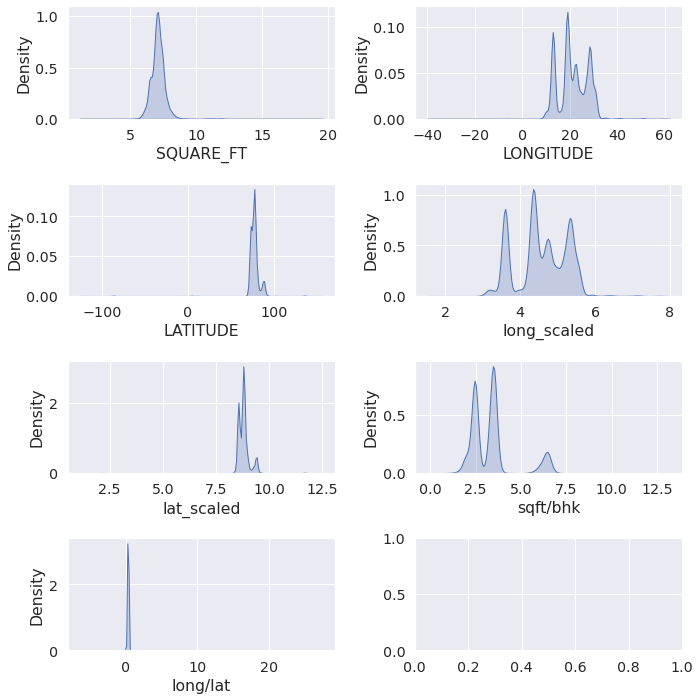

In [ ]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = [ax for axes_row in axes for ax in axes_row]
for i, c in enumerate(num_cols):
    plot = sns.kdeplot(data=trn, x=c, ax=axes[i], fill=True)
plt.tight_layout()

In [ ]:
# fold = KFold(n_splits=5,shuffle = True, random_state=True)
# i=1
# scores=[]
# for train, test in fold.split(trn,target):
#     x_train, x_test = trn.values[train], trn.values[test]
#     y_train, y_test = target.values[train], target.values[test] 
#     model = LGBMRegressor()

#     model.fit(x_train, y_train)
#     preds = model.predict(x_test)

#     # feature_importances = pd.DataFrame(model.feature_importances_,
#     #                                    index = TRAIN_FINAL.columns,
#     #                                     columns=['importance'])
#     #sum=feature_importances.values
#     #l.append(sum)
#     #score = log_loss(y_test, preds)
#     score = np.sqrt(mean_squared_error(y_test, preds))
#     scores.append(score)
#     print(score)
#     i+=1
# print(f"Average is ==============: ", np.sum(scores)/len(scores))

## LGBM

In [ ]:
target = trn.pop('TARGET(PRICE_IN_LACS)')

In [ ]:
trn.head()

,UNDER_CONSTRUCTION,RERA,BHK_NO.,SQUARE_FT,READY_TO_MOVE,RESALE,LONGITUDE,LATITUDE,long_scaled,lat_scaled,clusters,Tier,sqft/bhk,long/lat
0,0,0,2,7.171070,1,1,12.969910,77.597960,3.601376,8.808970,0,2,3.585535,0.167142
1,0,0,2,7.151485,1,1,12.274538,76.644605,3.503504,8.754690,0,1,3.575743,0.160149
2,0,0,2,6.839647,1,1,12.778033,77.632191,3.574637,8.810913,0,2,3.419824,0.164597
3,0,1,2,6.836175,1,1,28.642300,77.344500,5.351850,8.794572,3,1,3.418087,0.370321
4,1,0,2,6.907765,0,1,22.592200,88.484911,4.753125,9.406642,5,2,3.453882,0.255323


In [ ]:
train.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5
